In [2]:
import sys
sys.path.append('/Users/theohanon/Desktop/Master II/TFE/Experiences/SAMPTA')

import numpy as np
import pyshtools
from inr import SphericalINR, SIREN, train
from utils import plot_SHT_coeffs, plot_losses
from chebychev import Chebyshev
from sampling import sample_s2
from plotting import plot_sphere
import matplotlib.pyplot as plt


import torch_harmonics as th
import torch
from sklearn.preprocessing import StandardScaler
import imageio.v3 as iio


In [3]:
L = 200
phi, theta, (nlon, nlat) = sample_s2(L, sampling = "gl", torch_tensor = True)

In [4]:
coefficients = pyshtools.datasets.Earth.Earth2014.tbi(lmax = 200)

In [5]:
world_map = coefficients.expand(lon = phi.numpy().flatten(), colat = theta.numpy().flatten(), degrees=False, nthreads=0).reshape(nlat, nlon)

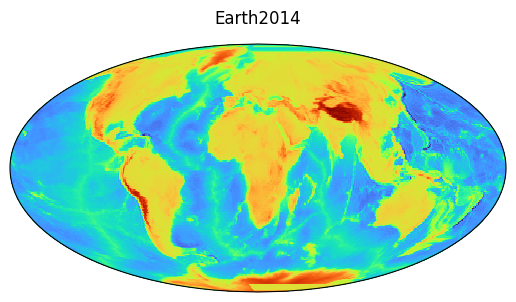

In [6]:
plot_sphere(world_map, molweide=True, cmap = "turbo", title = "Earth2014")
plt.show()

In [7]:
scaler = StandardScaler()
world_map_scaled = scaler.fit_transform(world_map)

X = torch.stack([theta.flatten(), phi.flatten()], dim=-1).float()
y = torch.tensor(world_map_scaled.copy()).flatten().unsqueeze(1).float()

In [8]:
activation_degrees = [(4, 4), (5, 5), (10, 10), (5, 3), (8, 2), (10, 2), (2, 8), (2, 10)]
dict_losses = {}
dict_predictions = {}

In [13]:
for (deg_first, deg_subseq) in activation_degrees:

    shinr = SphericalINR(

        L0 = 15, 
        Q = 3,
        hidden_features = 100, 
        activation = Chebyshev(order = deg_subseq, alpha = 1.0), 
        first_activation=Chebyshev(order = deg_first, alpha = 1.0)
        
    )

    dict_losses[(deg_first, deg_subseq)] = train(
        model = shinr, 
        x = X, 
        y = y, 
        epochs = 1,#000, 
        batch_size=2048,
        optimizer = torch.optim.AdamW(shinr.parameters(), lr=1e-3),
        loss_fn= torch.nn.MSELoss())
    
    pred = shinr(X).detach().numpy().reshape(nlat, nlon)
    dict_predictions[(deg_first, deg_subseq)] = scaler.inverse_transform(pred)


shinr = SphericalINR(

    L0 = 15, 
    Q = 3,
    hidden_features = 100, 
    activation = torch.sin    
)

dict_losses["SphericalSIREN"] = train(
    model = shinr, 
    x = X, 
    y = y, 
    epochs = 1,#000, 
    batch_size=2048,
    optimizer = torch.optim.AdamW(shinr.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss())

pred = shinr(X).detach().numpy().reshape(nlat, nlon)
dict_predictions["SphericalSIREN"] = scaler.inverse_transform(pred)

In [14]:
siren = SIREN(

    in_features=2, 
    hidden_features=100,
    n_hidden_layers=5,
    out_features=1,
    first_omega_0=5.0,
    hidden_omega=5.0,
    
)

dict_losses["SIREN"] = train(
    model = siren, 
    x = X, 
    y = y, 
    epochs = 1,#000, 
    batch_size=2048,
    optimizer = torch.optim.AdamW(siren.parameters(), lr=1e-3),
    loss_fn= torch.nn.MSELoss())


pred = siren(X).detach().numpy().reshape(nlat, nlon)
dict_predictions["SIREN"] = scaler.inverse_transform(pred)

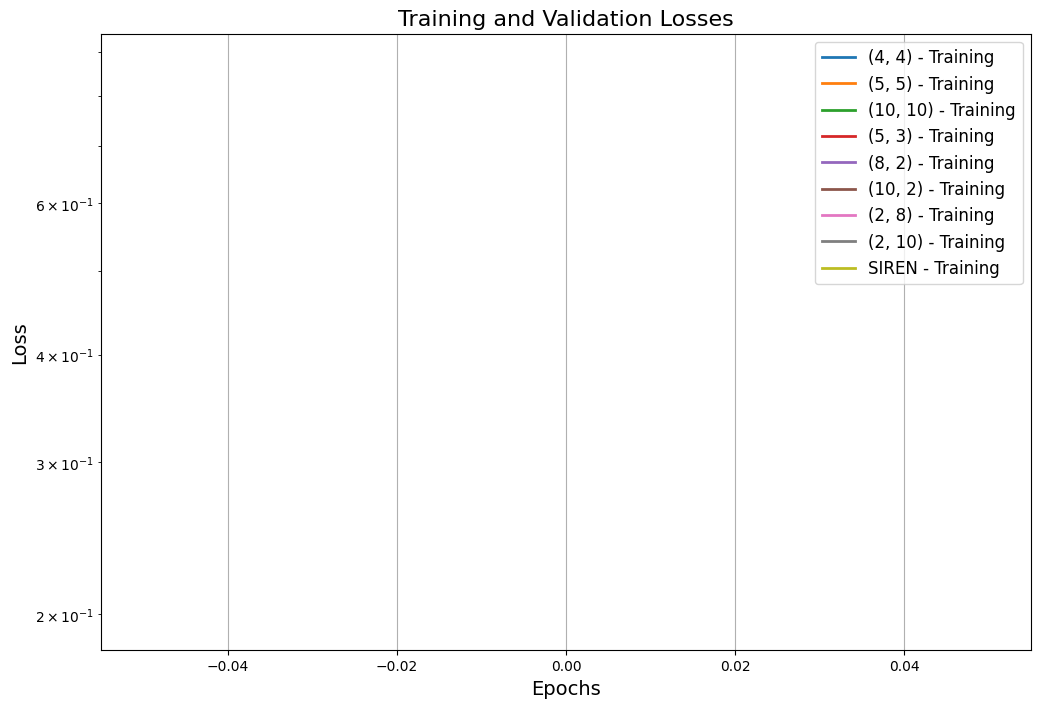

In [11]:
plot_losses(dict_losses)

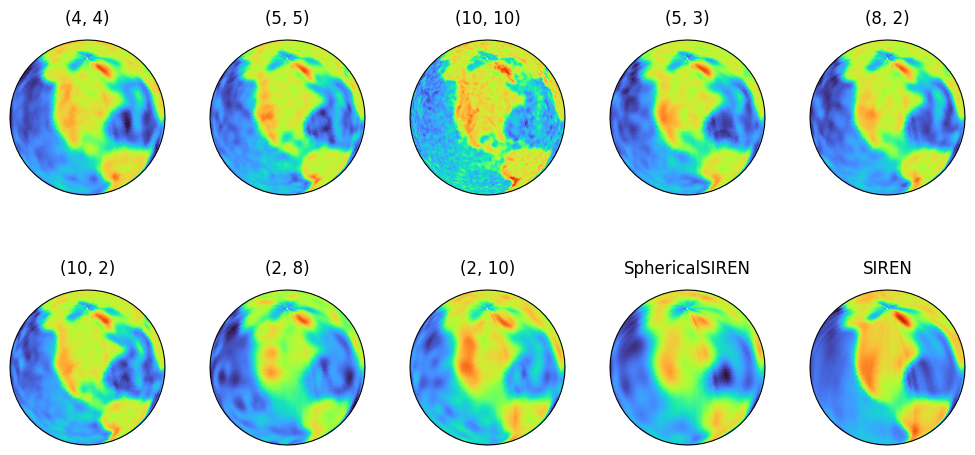

In [16]:
fig = plt.figure(figsize=(10, 5))
subfigs = fig.subfigures(2, 5)
subfigs = subfigs.flatten()

for i, (label, pred) in enumerate(dict_predictions.items()):
    plot_sphere(pred, cmap = "turbo", title = label, central_latitude=40, central_longitude=-90, fig=subfigs[i])

plt.show()

In [ ]:
sht = th.RealSHT(nlat = nlat, nlon = nlon, lmax = L, grid = "legendre-gauss")

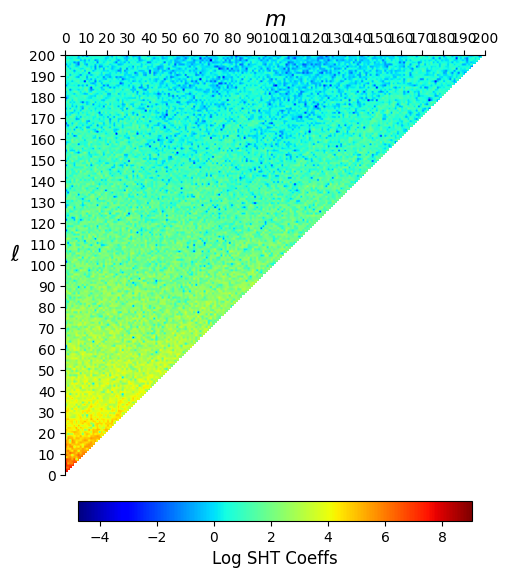

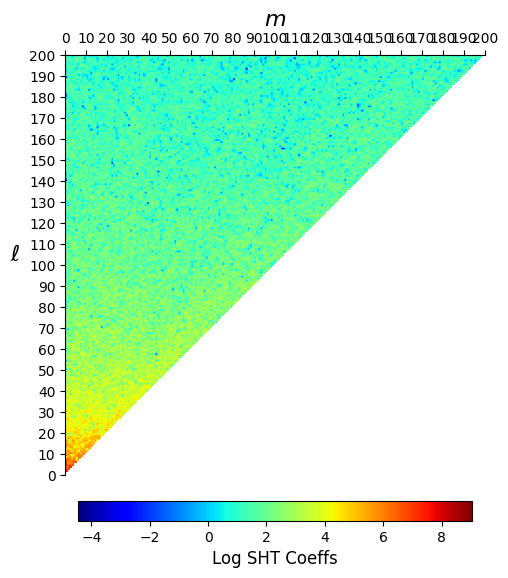

In [ ]:
coeffs = sht(torch.tensor(pred_sh))
plot_SHT_coeffs(coeffs, cmap ="jet")

coeffs_gt = sht(torch.tensor(world_map))
plot_SHT_coeffs(coeffs_gt, cmap ="jet")